### This notebooks explores how to use SHAP to explain the feature importance of a model. 

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
import optuna

In [3]:
# Load Iris dataset
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
# map species to numeric values
iris['species'] = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2})

In [8]:
# Split data into train and test sets
X = iris.drop('species', axis=1)
y = iris['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Train XGBoost model
def objective(trial):
    param = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    return accuracy

In [29]:
# Run optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-07-22 17:16:52,591] A new study created in memory with name: no-name-2a9a332b-346c-4c1d-80cc-c38469ae437a
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-07-22 17:16:52,819] Trial 0 finished with value: 1.0 and parameters: {'learning_rate': 0.004835635354169079, 'max_depth': 4}. Best is trial 0 with value: 1.0.
[I 2023-07-22 17:16:52,972] Trial 1 finished with value: 1.0 and parameters: {'learning_rate': 0.030590305819645704, 'max_depth': 9}. Best is trial 0 with value: 1.0.
[I 2023-07-22 17:16:53,038] Trial 2 finished with value: 1.0 and parameters: {'learning_rate': 0.06889153097445529, 'max_depth': 3}. Best is trial 0 with value: 1.0.
[I 2023-07-22 17:16:53,145] Trial 3 finished with value: 1.0 and parameters: {'learning_rate': 0.00257278179284527, 'max_depth': 9}. Best is trial 0 with value: 1.0.
[I 2023-07-22 17:16:53,258] Tr

In [30]:
# best hyperparameters
best_params = study.best_params

In [31]:
best_params

{'learning_rate': 0.004835635354169079, 'max_depth': 4}

In [32]:
# Train model with best hyperparameters
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.004835635354169079,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [43]:
# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

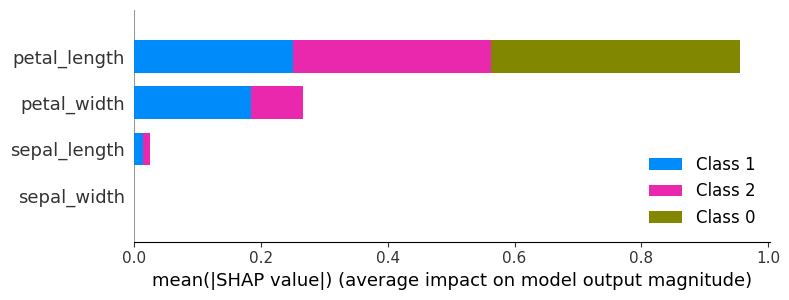

In [45]:
# Plot SHAP values
shap.summary_plot(shap_values, X_test, plot_type='bar')
